## Setup

Download the HEMnet Github Repository

In [1]:
!git clone https://github.com/BiomedicalMachineLearning/HEMnet.git

fatal: destination path 'HEMnet' already exists and is not an empty directory.


Install software packages

In [2]:
# Install openslide to open Whole Slide Images (WSIs)
!apt update && apt install -y openslide-tools
!pip install openslide-python

# Install SimpleITK for image registration - necessary for HEMnet package but not specifically for this Demo
!pip install SimpleITK

# Install Staintools for stain normalisation of H&E histopathology slides
!pip install spams    # Staintools dependency
!pip install staintools

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
49 packages can be upgraded. Run '

## Load Data from TCGA

Install GDC-client so that we can download slides from TCGA


In [27]:
!wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
!unzip -o gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
# Add gdc-client to path
!cp -pi ./gdc-client /usr/local/bin

--2020-11-19 04:07:11--  https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
Resolving gdc.cancer.gov (gdc.cancer.gov)... 192.170.230.224, 2605:9a00:10:4008::101
Connecting to gdc.cancer.gov (gdc.cancer.gov)|192.170.230.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19603683 (19M) [application/zip]
Saving to: ‘gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip’

gdc-client_v1.6.0_U 100%[===================>]  18.70M  8.99MB/s    in 2.1s    

2020-11-19 04:07:13 (8.99 MB/s) - ‘gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip’ saved [19603683/19603683]

Archive:  gdc-client_v1.6.0_Ubuntu_x64-py3.7_0.zip
  inflating: gdc-client              


Download an example slide - as specified in our manifest file

In [28]:
!wget https://raw.githubusercontent.com/BiomedicalMachineLearning/HEMnet/master/Demo/gdc_manifest_cm_6677.txt
!gdc-client download -m gdc_manifest_cm_6677.txt

--2020-11-19 04:07:13--  https://raw.githubusercontent.com/BiomedicalMachineLearning/HEMnet/master/Demo/gdc_manifest_cm_6677.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182 [text/plain]
Saving to: ‘gdc_manifest_cm_6677.txt’

gdc_manifest_cm_667 100%[===================>]     182  --.-KB/s    in 0s      

2020-11-19 04:07:13 (9.74 MB/s) - ‘gdc_manifest_cm_6677.txt’ saved [182/182]

100% [#############################################] Time:  0:00:37  26.4 MiB/s 
Successfully downloaded: 1


# Import Python Packages

In [22]:
import ast
import configparser
import cv2 as cv
import importlib
import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import mlab
import multiprocessing as mp
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
from scipy.stats import norm
import seaborn as sns
from sklearn.mixture import GaussianMixture
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
import time
import timeit
from tensorflow import keras
from tensorflow.keras.models import model_from_json
import sys

In [4]:
# Import HEMnet package
BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.joinpath('HEMnet/HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *
from normaliser import IterativeNormaliser

In [75]:
import normaliser
importlib.reload(normaliser)
from normaliser import IterativeNormaliser

In [5]:
# %matplotlib notebook

#############
# Functions #
#############

def imshow(img_cv):
    """Display OpenCV images with Pillow
    
    Parameters
    ----------
    img_cv : OpenCV image
    
    Returns
    -------
    img_pil : Pillow(rgb) image
    """
    #Convert grayscale image
    if len(img_cv.shape) == 2:
        return Image.fromarray(img_cv, 'L')
    #Convert BGR image
    elif img_cv.shape[2] == 3:
        img_rgb = img_cv[:, :, ::-1]    #Convert from BGR to RGB
        return Image.fromarray(img_rgb)

# Configure Input Parameters

In [6]:
# User Input parameters
SLIDES_PATH = Path('.')
OUTPUT_PATH = Path('.')
MODEL_JSON_PATH = Path('./HEMnet/Demo/colorectal_cancer_model.json')
MODEL_WEIGHTS_PATH = Path('./HEMnet/Demo/colorectal_cancer_model_weights.h5')
NORMALISER_PATH = Path('./HEMnet/Demo/stain_normaliser.ini')

PROCESSING_MAG = 2
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = True
NN_TILE_SIZE = 224
CNN_BASE = 'vgg16'

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi, bbox_inches = 'tight')
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slide_paths = []
for slide_path in SLIDES_PATH.glob('**/*.svs'):
    relative_path = slide_path.relative_to(SLIDES_PATH)
    slide_paths.append(relative_path)
slide_paths.sort()
slide_paths

[PosixPath('1f15485a-15dd-460d-b6a3-97e999c07a68/TCGA-CM-6677-01Z-00-DX1.e3428c0a-a194-4e38-b105-8244701fcc71.svs')]

In [7]:
# slide_info_df = pd.DataFrame({'Slide_Name' : np.nan,
#  'Sample_Name' : np.nan,
#  'Tiles': np.nan,
#  'Cancer_Tiles' : np.nan,
#  'Cancer_Tile_Proportion' : np.nan,
#  'Average_Sigmoid_Value' : np.nan,
#  'Weighted_Average_Sigmoid_Value' : np.nan,
#  'Cancer_Area_Proportion' : np.nan}, index = [0])
verbose_print(f'Found {len(slide_paths)} slide(s)')

Found 1 slide(s)


## Create stain normaliser and load template slide configuration



In [35]:
normaliser = IterativeNormaliser(NORMALISER_METHOD, STANDARDISE_LUMINOSITY)

# Load normaliser that has been pre-fitted to the template slide
# config = configparser.ConfigParser()
# config.read(NORMALISER_PATH)
normaliser.normaliser.maxC_target = np.array([[1.92984228, 1.13784735]])
normaliser.normaliser.stain_matrix_target = np.array([[0.48011481, 0.75784925, 0.44176271],
       [0.20473679, 0.8075991 , 0.55305202]])

## Load model - pretrained with HEMnet on colorectal cancer slides

In [9]:
# Load json and create model
json_file = open(MODEL_JSON_PATH, 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# Load weights into new model
model.load_weights(MODEL_WEIGHTS_PATH)
print("Loaded pretrained model")

Loaded pretrained model


In [10]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# verbose_print(model.summary())

# Open TCGA slide(s)

In [11]:
# Open first slide
SLIDE_NUM = 0

slide_path_absolute = SLIDES_PATH.joinpath(slide_paths[SLIDE_NUM])
slide_stem = slide_path_absolute.stem
verbose_print(f'Processing Slide: {slide_stem}')
SAMPLE_NAME = slide_stem.split('.')[0]
PREFIX = f'{SAMPLE_NAME}_{PROCESSING_MAG}x'
slide_info = {'Slide_Name': slide_path_absolute.name, 'Sample_Name': SAMPLE_NAME}

Processing Slide: TCGA-CM-6677-01Z-00-DX1.e3428c0a-a194-4e38-b105-8244701fcc71


In [12]:
#Load Slide
he_slide = open_slide(str(slide_path_absolute))
he = read_slide_at_mag(he_slide, PROCESSING_MAG).convert('RGB')
verbose_save_img(he, OUTPUT_PATH.joinpath(f'{PREFIX}.jpeg'), 'JPEG' )

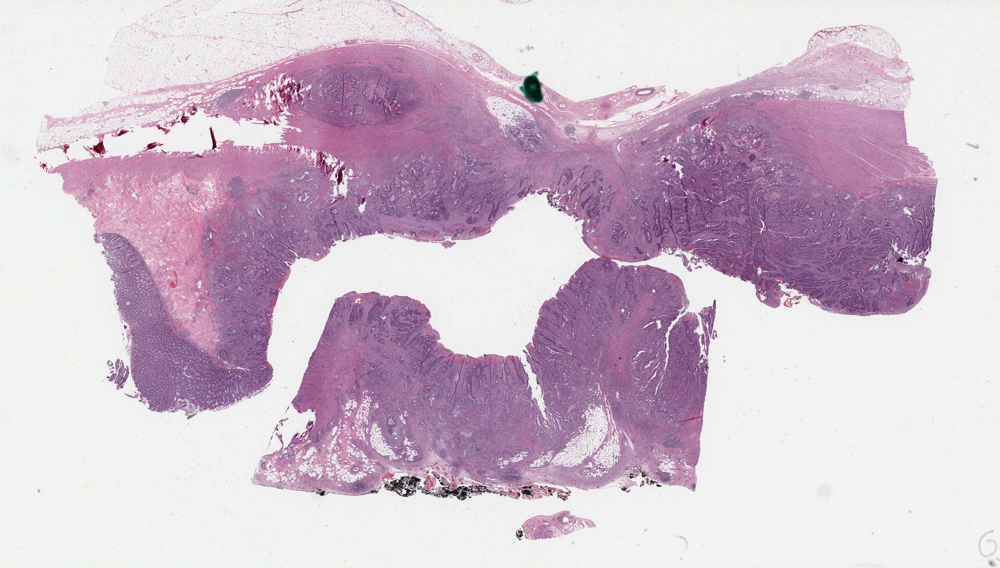

In [13]:
# Preview TCGA slide
thumbnail(he)

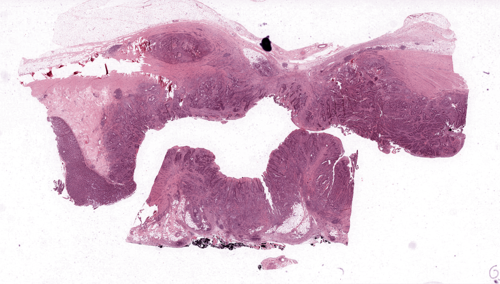

In [36]:
#Normalise H&E slide against the template slide 
normaliser.fit_source(he)
he_norm = normaliser.transform_tile(he)
verbose_save_img(he_norm, OUTPUT_PATH.joinpath(f'{PREFIX}_normalised.jpeg'), 'JPEG' )
thumbnail(he_norm, (500,500))

# H&E Masking

In [37]:
he_filtered = filter_green(he_norm)
he_filtered = filter_grays(he_norm, tolerance = 15)

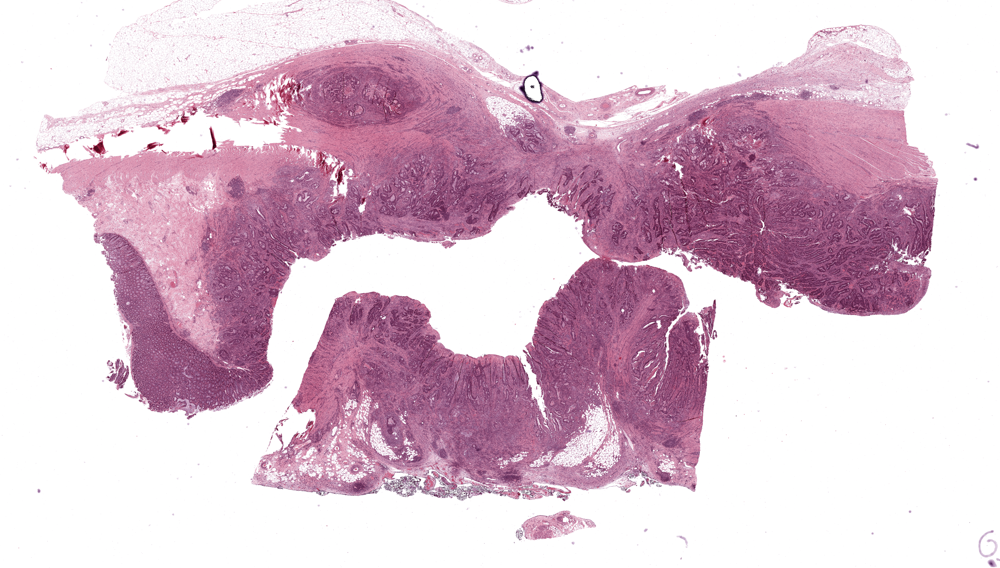

In [38]:
thumbnail(he_filtered)

In [39]:
he_mask = he_filtered.convert('L')
#plt.imshow(np.array(he_mask) == 255)

In [40]:
he_cv = np.array(he_norm)[:, :, ::-1]   #Convert RGB to BGR

#thumbnail(imshow(he_cv))

In [41]:
# Use the filtered H&E image to form the initial mask for Grabcut
he_mask_initial = (np.array(he_mask) != 255).astype(np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

he_cut = he_cv.copy()
cv.grabCut(he_cut,he_mask_initial,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
he_mask_final = np.where((he_mask_initial==2)|(he_mask_initial==0),0,1).astype('uint8')

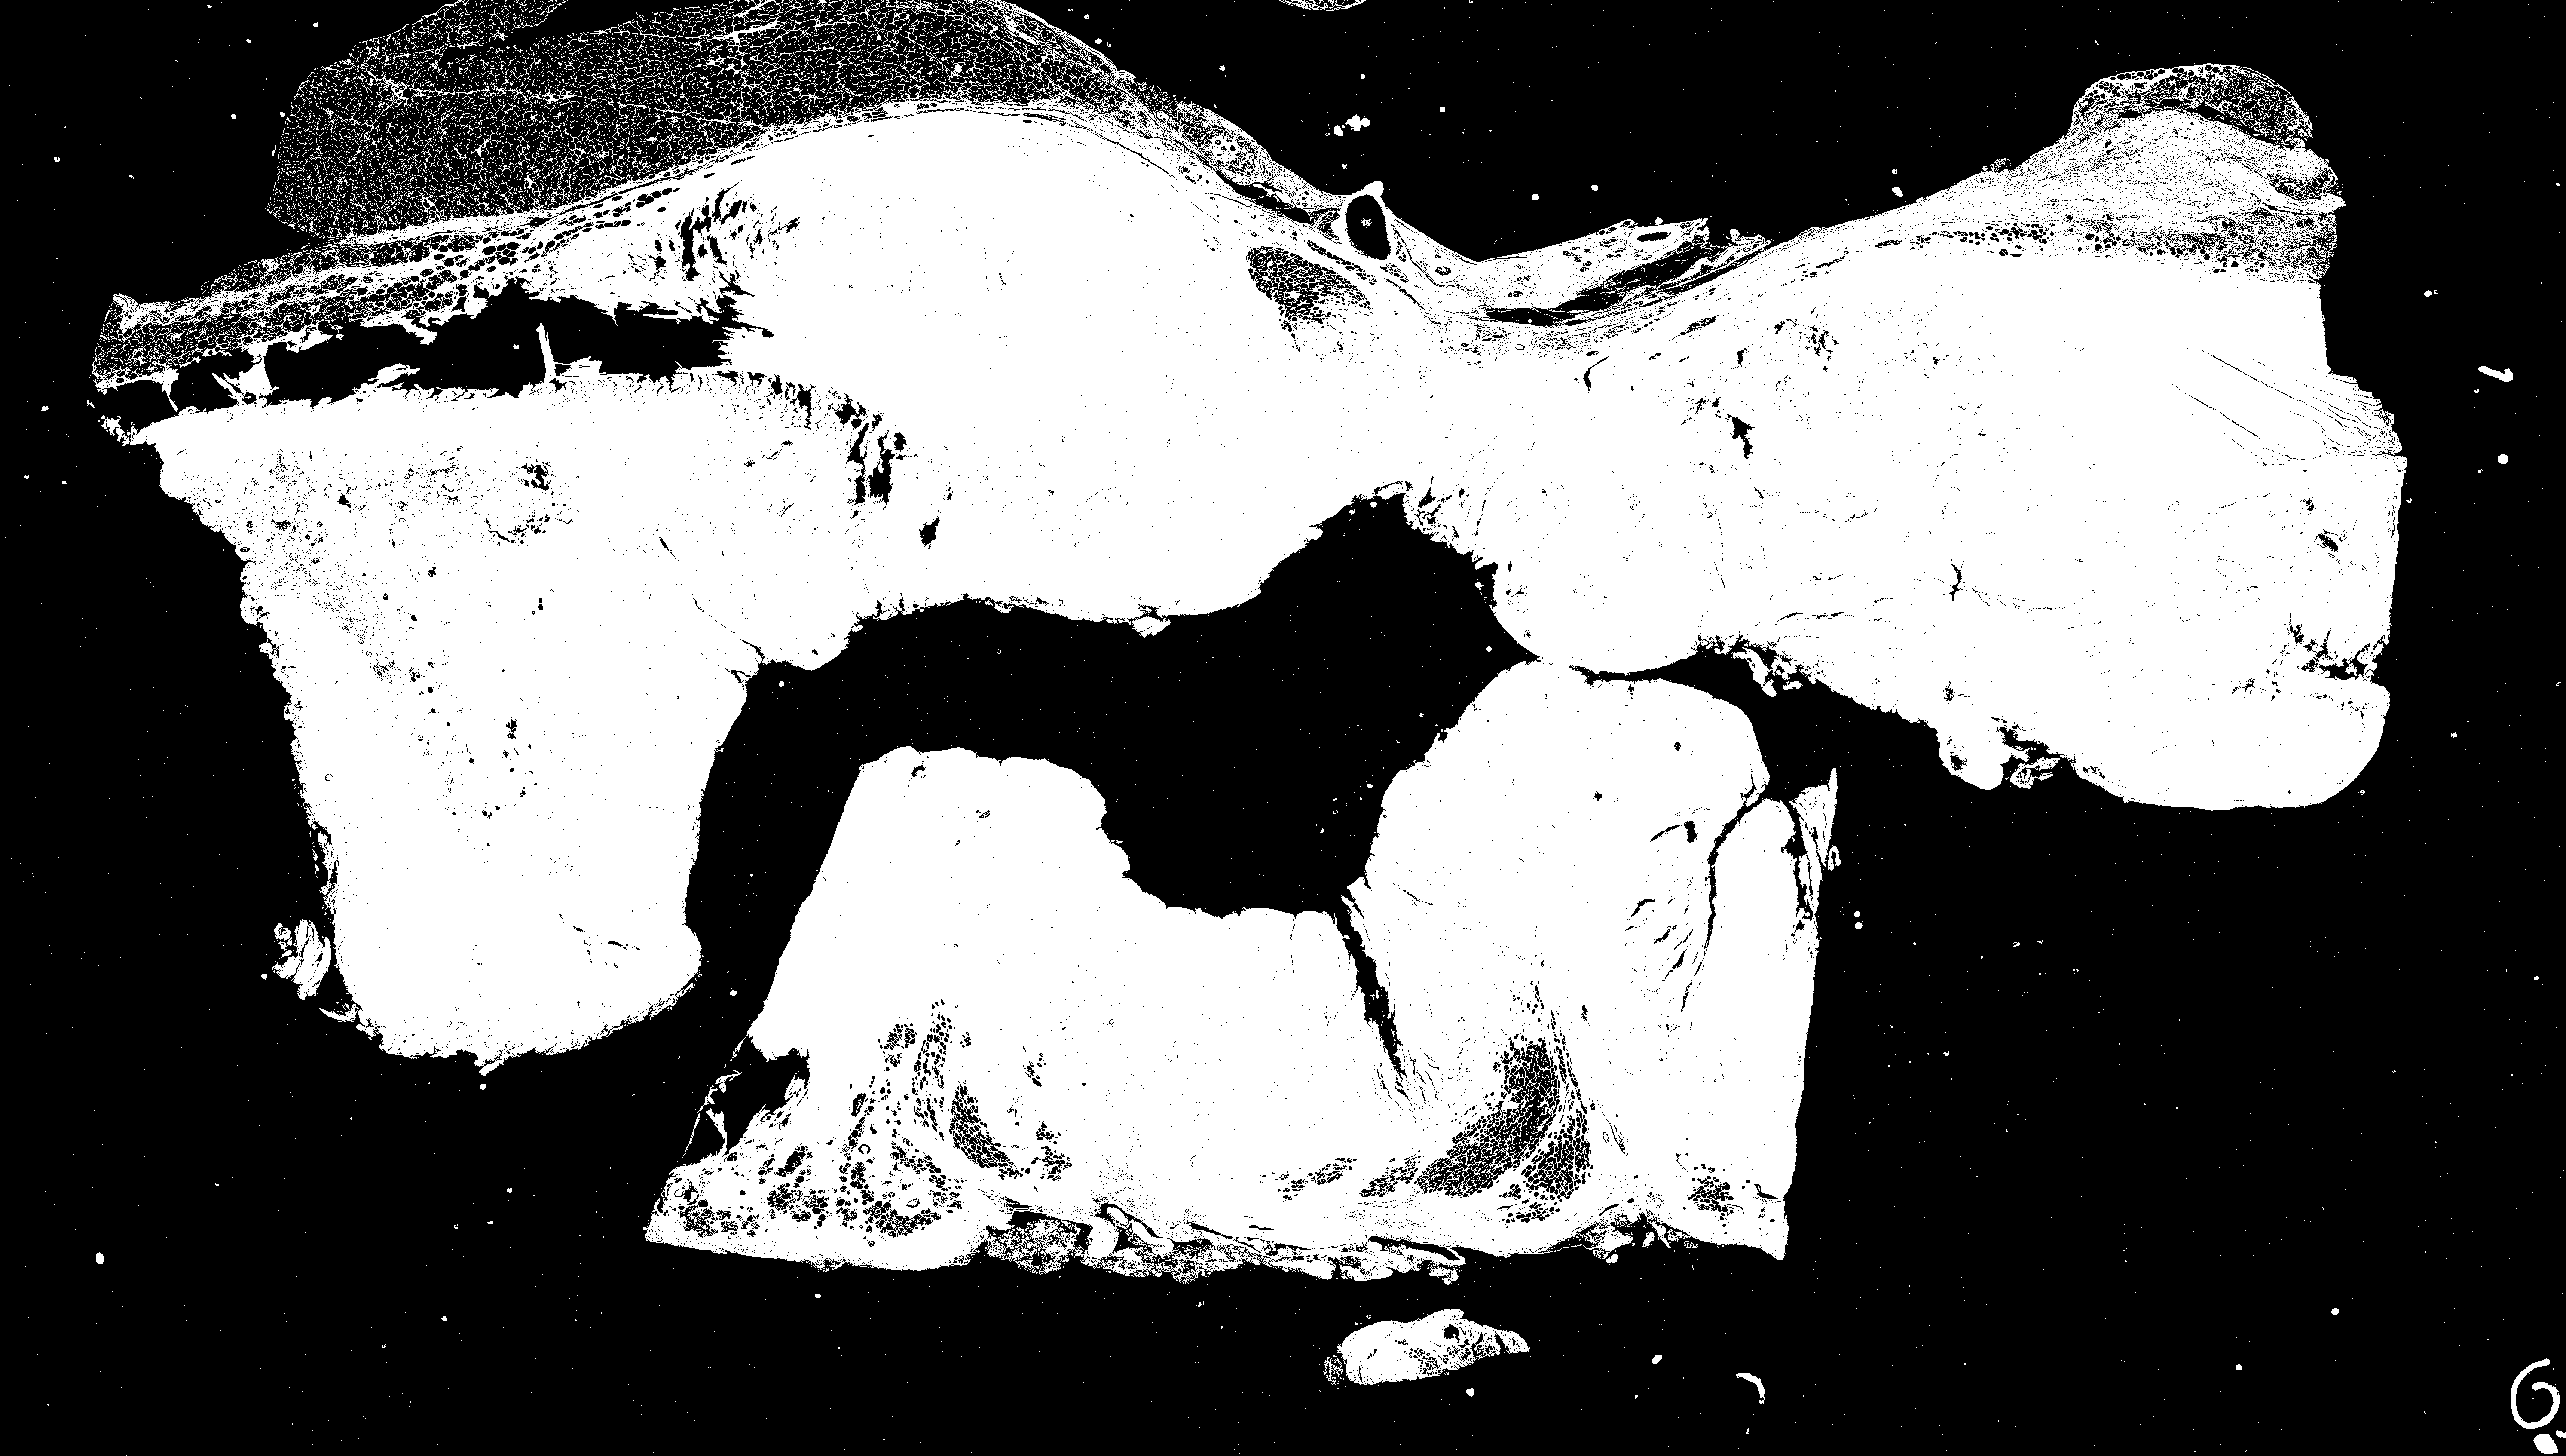

In [42]:
imshow(he_mask_final*255)

In [43]:
# Remove small debris using a rough 'filled in' mask of the tissue
kernal_64 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (64,64))
he_mask_closed = cv.morphologyEx(he_mask_final, cv.MORPH_CLOSE, kernal_64)
he_mask_opened = cv.morphologyEx(he_mask_closed, cv.MORPH_OPEN, kernal_64)
#imshow((he_mask_opened * 255).astype(np.uint8))

he_mask_cleaned = cv.bitwise_and(he_mask_final, he_mask_final, mask = he_mask_opened)
he_mask_cleaned_pil = Image.fromarray(he_mask_cleaned.astype(np.bool))
#he_mask_cleaned_pil

In [44]:
he_cut = he_cut*he_mask_cleaned[:,:,np.newaxis]

imshow(he_cut)

In [45]:
#Find tile pixel size for processing mag image that is equivalent to the tile mag image 
tile_size = NN_TILE_SIZE * PROCESSING_MAG / TILE_MAG

In [46]:
tgen = tile_gen(he_mask_cleaned_pil, tile_size)

In [ ]:
# Calculate the proportion of each tile occupied by tissue
tgen = tile_gen(he_mask_cleaned_pil, tile_size)
width, height = next(tgen)
counts = []
proportions = []
for tile in tgen:
    tile_np = np.array(tile)
    tile_count = np.count_nonzero(tile_np)
    total_pixels = tile_np.size
    counts.append(tile_count)
    proportions.append(tile_count / total_pixels)
hist = np.reshape(np.array(counts), (height, width))
hist_proportion = np.reshape(np.array(proportions), (height, width))

In [ ]:
# Crop normalised H&E to tiled area for heatmap overlay
width_mag, height_mag = get_size_for_mag(he_slide, TILE_MAG)
width_tiled = round((width_mag - width_mag % NN_TILE_SIZE) * PROCESSING_MAG / TILE_MAG) 
height_tiled = round((height_mag - height_mag % NN_TILE_SIZE) * PROCESSING_MAG / TILE_MAG)
he_norm_cropped = he_norm.crop((0, 0, width_tiled, height_tiled))

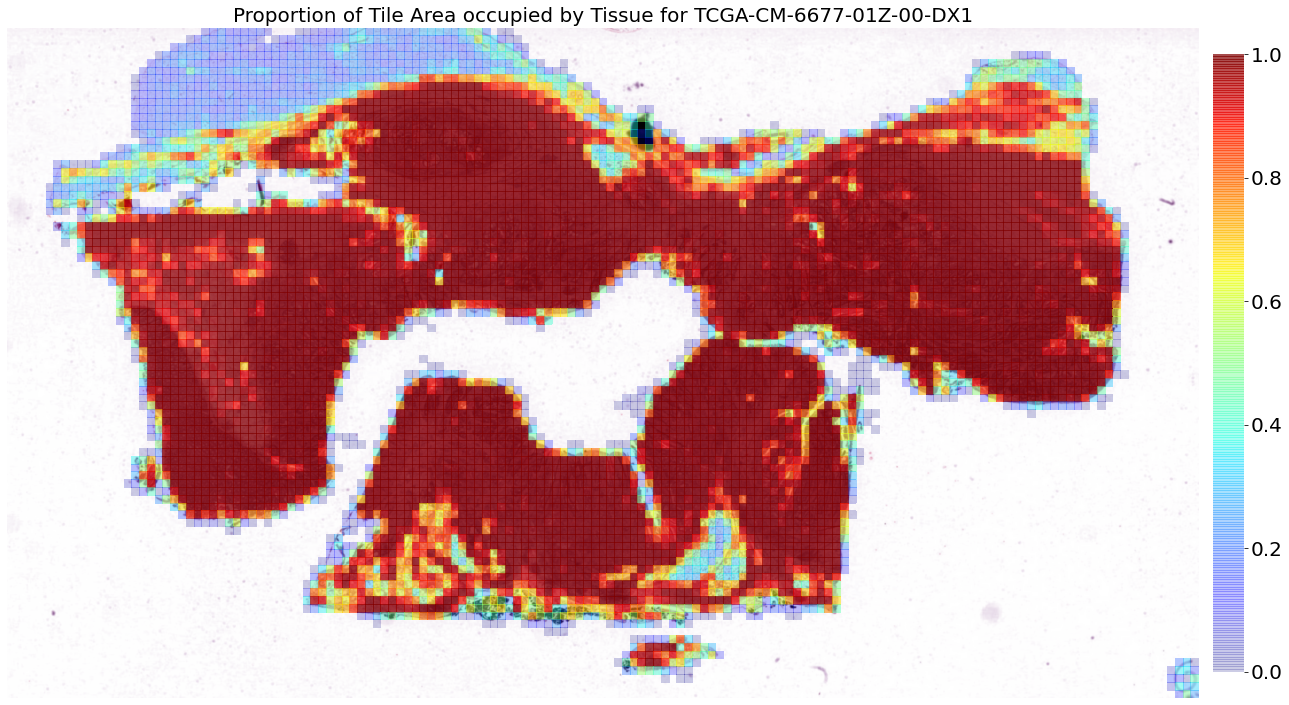

In [50]:
# Generate a semi-transparent colourmap for plotting heatmaps over images
cmap = plt.cm.jet
my_cmap = cmap(np.arange(cmap.N))  # Get the colormap colours
my_cmap[:, -1] = np.linspace(0.2, 0.7, cmap.N)  # Set alpha as a linear gradient
my_cmap = ListedColormap(my_cmap)  # Create new colourmap

# Overlay translucent heatmap over H&E tissue mask
tissue_proportion_heatmap = plt.figure(figsize = (20,10))
hmax = sns.heatmap(hist_proportion, vmin = 0, vmax = 1, square = True, xticklabels = False, yticklabels = False,
                   cmap = my_cmap, mask = (hist_proportion == 0),
                   cbar_kws = {'pad': 0.01, 'shrink': 0.9})
cbar_axes =  hmax.figure.axes[-1]
#cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize = 20)
hmax.imshow(np.array(he_norm_cropped), 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            interpolation = 'bicubic',
            zorder = 0)
hmax.set_title(f'Proportion of Tile Area occupied by Tissue for {SAMPLE_NAME}', fontsize = 20)
tissue_proportion_heatmap.tight_layout()
# verbose_save_fig(tissue_proportion_heatmap, OUTPUT_PATH.joinpath(f'{SAMPLE_NAME}_tissue_proportion_heatmap.jpeg'))

# Extract only tissue tiles from slide

In [51]:
def tile_from_slide(x, y, wsi, mag, tile_size_at_mag):
    """Read a tile from a Whole Slide Image (WSI) based on tile x and y coordinates
    """
    # Size of WSI at Max Magnification (Level 0)
    width_max, height_max = wsi.level_dimensions[0]
    # Calculate maximum number tiles 
    width_mag, height_mag = get_size_for_mag(wsi, mag)
    x_tiles = max_tiles(width_mag, tile_size_at_mag, overlap = 0)
    y_tiles = max_tiles(height_mag, tile_size_at_mag, overlap = 0)
    assert x <= x_tiles, "Tile x-coordinate outside image bounds"
    assert y <= y_tiles, "Tile y-coordinate outside image bounds"
    # Tile is first read from WSI at max magnification, then downscaled to specified mag
    scale = highest_mag(wsi)/mag
    scaled_tile_size = scale * tile_size_at_mag
    # Calculate x and y pixel coordinates on WSI at max magnification
    x_coord = int(round(x * scaled_tile_size))
    y_coord = int(round(y * scaled_tile_size))
    tile = wsi.read_region((x_coord, y_coord), 0, (round(scaled_tile_size), round(scaled_tile_size)))
    return tile.resize((round(tile_size_at_mag), round(tile_size_at_mag)), resample = Image.BICUBIC)   

In [52]:
# Interactively view individual tiles
width_mag, height_mag = get_size_for_mag(he_slide, TILE_MAG)
x_tiles = max_tiles(width_mag, NN_TILE_SIZE, overlap = 0)
y_tiles = max_tiles(height_mag, NN_TILE_SIZE, overlap = 0)

interact(tile_from_slide
         , x = widgets.IntSlider(min = 0, max = x_tiles, step = 1, value = 0, continuous_update = True)
         , y = widgets.IntSlider(min = 0, max = y_tiles, step = 1, value = 0, continuous_update = True)
         , wsi = fixed(he_slide)
         , mag = fixed(TILE_MAG), tile_size_at_mag = fixed(NN_TILE_SIZE))

interactive(children=(IntSlider(value=0, description='x', max=153), IntSlider(value=0, description='y', max=86…

<function __main__.tile_from_slide>

In [ ]:
tissue_tile_coords = np.argwhere(hist_proportion > 0).astype(np.uint16)

# Get a list of tissue tile images 
tissue_tile_imgs = []
for y, x in tissue_tile_coords:
    tissue_tile_imgs.append(tile_from_slide(x, y, he_slide, TILE_MAG, NN_TILE_SIZE).convert('RGB'))

In [ ]:
tissue_tile_imgs[19]

In [ ]:
t0 = time.time()
pool = mp.Pool(processes = 2)
#tissue_tile_imgs_norm = pool.map(normaliser.transform_tile, tissue_tile_imgs) 
tissue_tile_imgs_norm = [x for x in map(normaliser.transform_tile, tissue_tile_imgs)]
t1 = time.time()
print(t1 - t0)

In [ ]:
tissue_tiles_number = len(tissue_tile_imgs_norm)
slide_info['Tiles'] = tissue_tiles_number
verbose_print(f'Found {tissue_tiles_number} tissue tiles')

In [ ]:
tissue_tile_imgs_norm[100]

### Inference with pre-trained model (CPU only) 

In [41]:
# model_base = keras.applications.VGG16(
#     weights = 'imagenet'
#     , input_shape = (224, 224, 3)
#     , pooling = 'max'
#     , include_top = False) # Do not include the ImageNet classifier at the top

In [42]:
# model_base.trainable = False
# model = model_base.output
# model = keras.layers.Dense(256, activation='relu')(model)
# preds = keras.layers.Dense(1, activation='sigmoid')(model)
# model = keras.Model(inputs=model_base.input, outputs=preds)
# model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.input_shape

(None, 224, 224, 3)

In [44]:
# test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# # test_generator = test_datagen.flow_from_directory(TEST_INPUT_PATH,
# #                                                       classes=['cancer', 'non-cancer'],
# #                                                       target_size= (224, 224, 3),
# #                                                       batch_size=1,
# #                                                       class_mode='binary',
# #                                                       shuffle=False)
# test_datagen.fit([np.array(img) for img in tissue_tile_imgs_norm])

In [45]:
predictions = []
for i in range(len(tissue_tile_imgs_norm)):
    predictions.append(model.predict(np.expand_dims(np.array(tissue_tile_imgs_norm[i])/ 255, axis = 0))[0][0])

NameError: ignored

In [ ]:
predictions

In [ ]:
tile_predictions = [(x, y, z) for (x, y), z in zip(tissue_tile_coords, predictions)]

In [ ]:
def plot_predictions(img, tile_predictions, tile_size):
    img_overlay = img.copy()
    d = ImageDraw.Draw(img_overlay)
    width = int(np.round(tile_size * 0.07))
    for row, column, prediction in tile_predictions:
        x_top_left, y_top_left = np.round(column * tile_size), np.round(row * tile_size)
        x_bottom_right, y_bottom_right = np.round(x_top_left + tile_size), np.round(y_top_left + tile_size)
        if prediction >= 0.5:
            outline = 'lime'
        elif prediction < 0.5:
            outline = 'red'
        d.rectangle([(x_top_left, y_top_left), (x_bottom_right, y_bottom_right)], outline = outline, width = width)
    return img_overlay        

In [ ]:
predictions_overlay = plot_predictions(he_norm, tile_predictions, tile_size)
verbose_save_img(predictions_overlay, OUTPUT_PATH.joinpath(f'{PREFIX}_predictions.jpeg'), 'JPEG')
thumbnail(predictions_overlay)

In [ ]:
cancer_tiles = np.count_nonzero(np.array(predictions) < 0.5)
cancer_tile_proportion =  cancer_tiles / len(predictions)
slide_info['Cancer_Tiles'] = cancer_tiles
slide_info['Cancer_Tile_Proportion'] = cancer_tile_proportion
verbose_print(f'{cancer_tile_proportion * 100 :.2f}% of tissue tiles were predicted as cancer')

In [ ]:
# Create an array of tile predictions such that cancer = 1 and non-cancer = 0
tile_predictions_array = np.zeros(hist_proportion.shape)
for row, column, prediction in tile_predictions:
    tile_predictions_array[row, column] = 1 - prediction

In [ ]:
average_sigmoid_value = np.mean(1 - np.array(predictions))
slide_info['Average_Sigmoid_Value'] = average_sigmoid_value
average_sigmoid_value

In [ ]:
figure = plt.figure(figsize = (15, 7))
sns.distplot(1 - np.array(predictions), kde = False, bins = 100)

In [ ]:
hist_proportion_norm = hist_proportion / hist_proportion.sum()
weighted_average_sigmoid_value = np.sum(tile_predictions_array * hist_proportion_norm)
slide_info['Weighted_Average_Sigmoid_Value'] = weighted_average_sigmoid_value
weighted_average_sigmoid_value

In [ ]:
# Overlay raw predictions heatmap over H&E tissue mask
predictions_heatmap = plt.figure(figsize = (20,10))
hmax = sns.heatmap(tile_predictions_array, vmin = 0, vmax = 1, square = True, xticklabels = False, yticklabels = False,
                   cmap = my_cmap, mask = (hist_proportion == 0),
                   cbar_kws = {'pad': 0.01})
cbar_axes =  hmax.figure.axes[-1]
cbar_axes.tick_params(labelsize = 20)
hmax.imshow(np.array(he_norm_cropped), 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            interpolation = 'bicubic',
            zorder = 0)
hmax.set_title(f'HEMnet Predictions for {SAMPLE_NAME}', fontsize = 20)
predictions_heatmap.tight_layout()
verbose_save_fig(predictions_heatmap, OUTPUT_PATH.joinpath(f'{SAMPLE_NAME}_predictions_heatmap.jpeg'))

In [ ]:
cancer_tile_array = tile_predictions_array >= 0.5

In [ ]:
fig = plt.figure(figsize = (20,10))
hmax = sns.heatmap(cancer_tile_array, vmin = 0, vmax = 1, square = True, 
                   cmap = my_cmap, linewidths = 0, linecolor = (0, 0, 0, 0))
hmax.imshow(he_norm_cropped, 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            zorder = 0)

In [ ]:
cancer_tissue_area_array = cancer_tile_array * hist_proportion
fig = plt.figure(figsize = (20,10))
hmax = sns.heatmap(cancer_tissue_area_array, vmin = 0, vmax = 1, square = True, 
                   cmap = my_cmap, linewidths = 0, linecolor = (0, 0, 0, 0), mask = hist_proportion == 0)
hmax.imshow(he_norm_cropped, 
            cmap = 'gray', 
            aspect = hmax.get_aspect(),
            extent = hmax.get_xlim() + hmax.get_ylim(),
            zorder = 0)

In [ ]:
cancer_area_proportion = np.sum(cancer_tissue_area_array)/ np.sum(hist_proportion)
slide_info['Cancer_Area_Proportion'] = cancer_area_proportion
verbose_print(f'{cancer_area_proportion * 100 :.2f}% of tissue area was predicted as cancer')

In [ ]:
slide_info

In [ ]:
list(slide_info.keys())

In [ ]:
# list(slide_info.keys())

In [ ]:
slide_info_series = pd.Series(slide_info, name = SAMPLE_NAME)
slide_info_series2 = pd.Series(slide_info, name = 'SAMPLE_NAME')

In [ ]:
slide_info_series

In [ ]:
slide_info_df.append(slide_info_series2)
# slide_info_df.append(slide_info, index = [2], sort = False)
#slide_info_df = slide_info_df[list(slide_info.keys())]

In [ ]:
slide_info_df.append()

In [ ]:
HEMnet = HEMnetModel(cnn_base=CNN_BASE, num_gpus= 0)
input_size = (HEMnet.get_input_shape()[0], HEMnet.get_input_shape()[1])

# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(TEST_INPUT_PATH,
#                                                   classes=['cancer', 'non-cancer'],
#                                                   target_size=input_size,
#                                                   batch_size=1,
#                                                   class_mode='binary',
#                                                   shuffle=False)

# HEMnet.load_model(MODEL_PATH)
# HEMnet.predict(test_generator)

In [ ]:
HEMnet.summary